Downsampled Time Shape: torch.Size([217])
Downsampled BOLD Shape: torch.Size([217])
Total Duration (s): 434.0


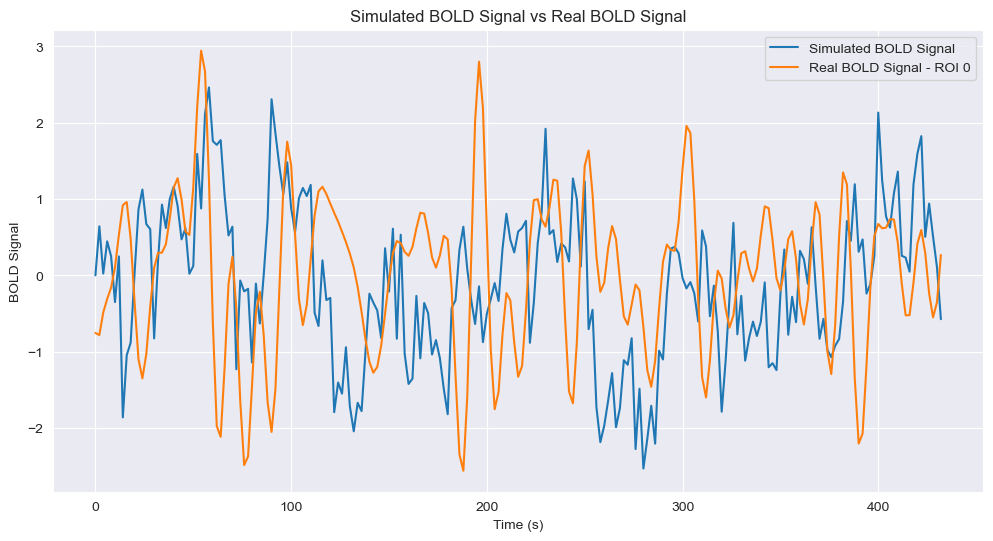

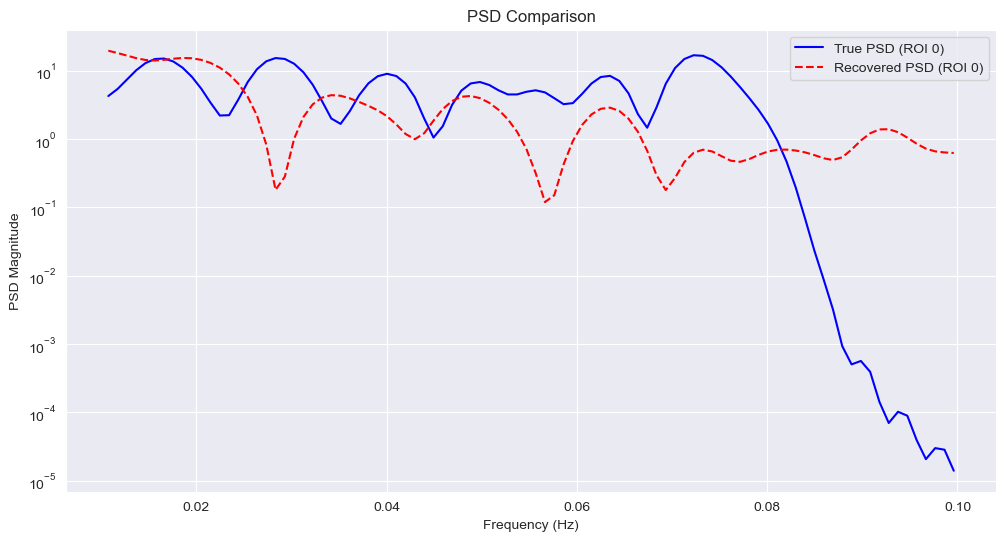

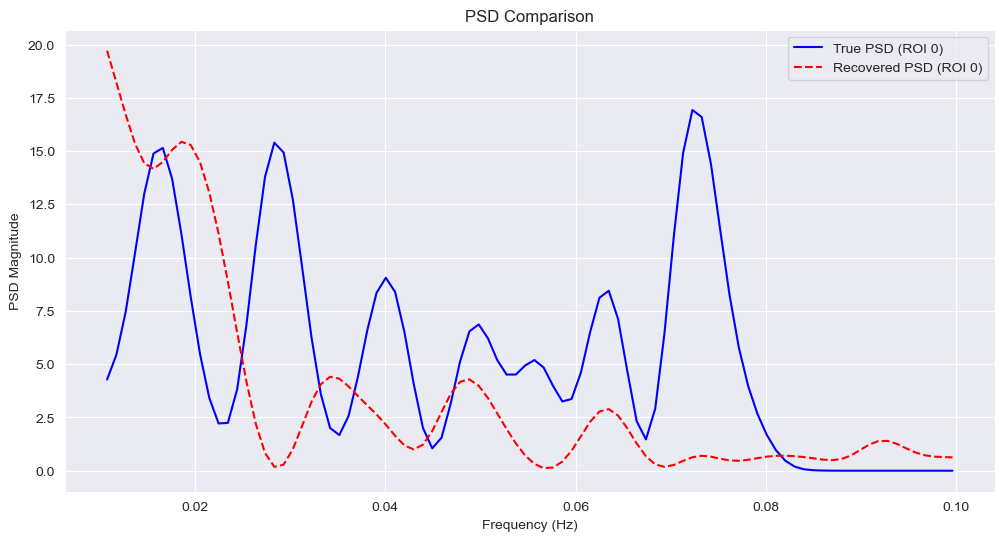

In [ ]:
from helper_functions import filter_frequencies, plot_psd_comparison
from scipy_to_torch import torch_csd
import numpy as np
from PDCM.PDCMBOLDModel import PDCMMODEL
import torch
import matplotlib.pyplot as plt
from PDCM.euler_maruyama import simulate_bold_euler_maruyama

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = PDCMMODEL(device=device)

# Simulation parameters
T = 434  # Total simulation time in seconds
h = 0.01
time = torch.arange(0, T, h, device=device)

t_down, bold_down = simulate_bold_euler_maruyama(
    model=model,
    time=time,
    h=h,
    alpha_v=1.0, beta_v=1.0,
    alpha_e=1.0, beta_e=1.0,
    desired_TR=2.0,
    add_state_noise=True,
    add_obs_noise=True
)

print("Downsampled Time Shape:", t_down.shape)
print("Downsampled BOLD Shape:", bold_down.shape)

# Detach the tensors and convert to NumPy arrays for plotting.
t_down_np = t_down.detach().cpu().numpy() if isinstance(t_down, torch.Tensor) else np.array(t_down)
bold_down_np = bold_down.detach().cpu().numpy() if isinstance(bold_down, torch.Tensor) else np.array(bold_down)

# Load real BOLD signal for comparison
roi_index = 52
exp = "PLCB"
file_path = f'/Users/xuenbei/Desktop/finalyearproject/time_series/sub-001-{exp}-ROI{roi_index}.txt'
time_series = np.loadtxt(file_path, delimiter=',')
TR = 2.0  # seconds
# Create time axis for the real data.
time_axis = np.arange(0, len(time_series) * TR, TR)
print("Total Duration (s):", len(time_series) * TR)

plt.figure(figsize=(12, 6))
plt.plot(t_down_np, bold_down_np/bold_down_np.std(), label='Simulated BOLD Signal')
plt.plot(time_axis, time_series/time_series.std(), label=f'Real BOLD Signal - ROI {roi_index}')
plt.xlabel('Time (s)')
plt.ylabel('BOLD Signal')
plt.title('Simulated BOLD Signal vs Real BOLD Signal')
plt.legend()
plt.grid(True)
plt.show()

# Normalise signals
bold_sim_norm = bold_down_np / bold_down_np.std()
bold_real_norm = time_series / time_series.std()

bold_sim_tensor = torch.tensor(bold_sim_norm, dtype=torch.float32, device=device)
f_sim, psd_sim = torch_csd(bold_sim_tensor, bold_sim_tensor, fs=0.5, nperseg=128, nfft=512)
f_sim, psd_sim = filter_frequencies(f_sim, psd_sim, 0.01, 0.1)

bold_real_tensor = torch.tensor(bold_real_norm, dtype=torch.float32, device=device)
f_real, psd_real = torch_csd(bold_real_tensor, bold_real_tensor, fs=0.5, nperseg=128, nfft=512)
f_real, psd_real = filter_frequencies(f_real, psd_real, 0.01, 0.1)

psd_sim = psd_sim.to(torch.complex64)
psd_real = psd_real.to(torch.complex64)

plot_psd_comparison(f_real, psd_real, psd_sim, f"PSD Comparison", roi_index, log_scale=True)
plot_psd_comparison(f_sim, psd_real, psd_sim, f"PSD Comparison", roi_index, log_scale=False)
